In [1]:
import pandas as pd
import numpy as np
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score
import pickle
import dill

import sys
numpy.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading data
df_in = pd.read_csv("Austin_Animal_Center_Intakes.csv")
df_out = pd.read_csv("Austin_Animal_Center_Outcomes.csv")
df = pd.merge(df_in,df_out,on = ["Animal ID","Name"])

# Functions

In [3]:
#renaming columns and values
def all_lower(df):
    
    df.columns = df.columns.str.replace(' ','_').str.lower()
    for column in df.columns:
        if column in ['datetime_x','datetime_y']:
            pass
        else:
            df[column] = df[column].str.replace(' ', '_').str.lower()
            
    return df

# functions to get new parameters from the column
def get_animal_sex(x):
    x = str(x)
    if x.find('_male') >= 0: return 'male'
    if x.find('_female') >= 0: return 'female'
    return 'other_sex'
def get_animal_neutered(x):
    x = str(x)
    if x.find('spayed') >= 0: return 'neutered'
    if x.find('neutered') >= 0: return 'neutered'
    if x.find('intact') >= 0: return 'intact'
    return 'other_neutered'

def age_to_months(item):
    # convert item to list if it is one string
    if type(item) is str:
        item = [item]
    age_to_months = np.zeros(len(item))
    for i in range(len(item)):
        # check if item[i] is str
        if type(item[i]) is str:
            if 'day' in item[i]:
                day_value = int(item[i].split(' ')[0])/30
                if day_value > 1:
                    day_value = 1
                age_to_months[i] = float(day_value)
            if 'week' in item[i]:
                week_value = int(item[i].split(' ')[0])/4
                if week_value > 1:
                    week_value = 1
                age_to_months[i] = float(week_value)
            if 'month' in item[i]:
                age_to_months[i] = int(item[i].split(' ')[0])
            if 'year' in item[i]:
                age_to_months[i] = int(item[i].split(' ')[0])*12    
        else:
            # item[i] is not a string but a nan
            age_to_months[i] = 0
    return age_to_months

def color_bucketing(color):
    if type(color) is str:
        if 'black/white' in str(color):
            return pd.Series(['black/white','bicolor'])
        if 'black' in str(color):
            return pd.Series(['black','unicolor'])
        if 'brown_tabby' in str(color):
            return pd.Series(['brown','bicolor'])
        if 'brown/white' in str(color):
            return pd.Series(['brown/white','bicolor'])
        if 'white' in str(color):
            return pd.Series(['white','unicolor'])
        if 'tan/white' in str(color):
            return pd.Series(['tan/white','bicolor'])
        if 'white/black' in str(color):
            return pd.Series(['white/black','bicolor'])
        if 'blue/white' in str(color):
            return pd.Series(['blue/white','bicolor'])
        if 'tricolor3' in str(color):
            return pd.Series(['tricolor','tricolor'])
        if 'black/tan' in str(color):
            return pd.Series(['black/tan','bicolor'])
        if 'brown/white' in str(color):
            return pd.Series(['brown/white','tricolor'])
        if 'tan' in str(color):
            return pd.Series(['tan','unicolor'])
        if 'orange' in str(color):
            return pd.Series(['orange','bicolor'])
        if 'brown' in str(color):
            return pd.Series(['brown','unicolor'])
        if 'white/brown' in str(color):
            return pd.Series(['white/brown','bicolor'])
        if 'brown_brindle/white' in str(color):
            return pd.Series(['white/brown','bicolor'])
        if 'white/tan' in str(color):
            return pd.Series(['white/tan','bicolor'])
        if 'black/brown' in str(color):
            return pd.Series(['black/brown','bicolor'])
        if 'blue' in str(color):
            return pd.Series(['blue','unicolor'])
        if 'calico' in str(color):
            return pd.Series(['calico','tricolor'])
        if 'tortie' in str(color):
            return pd.Series(['tortie','tricolor'])
        if 'brown/black' in str(color):
            return pd.Series(['brown/black','bicolor'])
        if 'blue_tabby' in str(color):
            return pd.Series(['brown','bicolor'])
        if 'red' in str(color):
            return pd.Series(['red','unicolor'])
        if 'red/white' in str(color):
            return pd.Series(['red/white','bicolor'])
        if 'orange_tabby/white' in str(color):
            return pd.Series(['orange/white','tricolor'])
        if 'torbie' in str(color):
            return pd.Series(['torbie','tricolor'])
        if 'brown_brindle' in str(color):
            return pd.Series(['brown','unicolor'])
        if 'tan/black' in str(color):
            return pd.Series(['tan/black','bicolor'])
        if 'chocolate/white' in str(color):
            return pd.Series(['chocolate/white','bicolor'])
        if 'yellow' in str(color):
            return pd.Series(['yellow','unicolor'])
        if 'sable' in str(color):
            return pd.Series(['sable','tricolor'])
        else:
            return pd.Series(['other_color','other_colortype'])
        
def time_extra_features(df):
    df["weekday_num_income"] = df["date_income"].dt.dayofweek
    df["weekend_income"] = np.where(df['weekday_num_income'] >= 5, 1, 0)
    df["month_num_income"] = df["date_income"].dt.month
    df["daytime_income"] = np.where(df['time_income'] >= '12:00:00', 1, 0)
    
    if 'date_outcome' in df.columns:
        df["weekday_num_outcome"] = df["date_outcome"].dt.dayofweek
        df["weekend_outcome"] = np.where(df['weekday_num_outcome'] >= 5, 1, 0)
        df["month_num_outcome"] = df["date_outcome"].dt.month
        df["daytime_outcome"] = np.where(df['time_outcome'] >= '12:00:00', 1, 0)
        
    return df

# bucketing the most usual dog breeds
def dog_breed_bucketing(breed):
    if type(breed) is str:
        if 'pit' in str(breed):
            return 'pit'
        if 'retriever' in str(breed):
            return 'retriever'
        if 'german shepherd' in str(breed):
            return 'german_shepherd'
        if ('shepherd' in str(breed)) & ('german' not in str(breed)):
            return 'shepherd'
        if 'australian' in str(breed):
            return 'australian'
        if 'hound' in str(breed):
            return 'hound'
        if 'chihuahua' in str(breed):
            return 'chihuahua'
        if 'dachshund' in str(breed):
            return 'dachshund'
        if 'boxer' in str(breed):
            return 'boxer'
        if 'poodle' in str(breed):
            return 'poodle'
        if ('border' in str(breed)) & ('collie' in str(breed)):
            return 'border_collie'
        if 'terrier' in str(breed):
            return 'terrier'
        if 'husky' in str(breed):
            return 'husky'
        if 'bulldog' in str(breed):
            return 'bulldog'
        if 'schnauzer' in str(breed):
            return 'schnauzer'
        if 'staffordshire' in str(breed):
            return 'staffordshire'
        if 'rottweiler' in str(breed):
            return 'rottweiler'
        else:
            return 'other_breed'
        
# bucketing the most usual cat breeds        
def cat_breed_bucketing(breed):
    if type(breed) is str:
        if 'shorthair' in str(breed):
            return 'shorthair'
        if 'medium' in str(breed):
            return 'mediumhair'
        if 'longhair' in str(breed):
            return 'longhair'
        if 'siamese' in str(breed):
            return 'siamese'
        else:
            return 'other_breed'
        
########## MODELING FUNCTIONS #######
# converting the categorical features into numerical features using the built in 'get_dummies' function
def numerical_convert(df):
    
    columns = ['intake_type', 'intake_condition',
               'animal_type', 'income_sex','income_neutered',
               'color_buckets', 'color_type', 'breed_buckets']

    for column in columns:
        # Get one hot encoding of columns 'vehicleType'
        one_hot = pd.get_dummies(df[column])
        # Drop column as it is now encoded
        df = df.drop(column,axis = 1)
        # Join the encoded df
        df = df.join(one_hot)
        
    return df

#fuction to find the best parameters for the model
def best_params(X_train,y_train):
    model = XGBClassifier()
    param_grid = { 
        'n_estimators': [75,150,175],
        'max_leaves': [10,15,20,30,40],
        'min_child_weight' : [5,10,20,30,40,50,60,80,100],
        'max_depth':[5,6,7],
        'learning_rate': [0.03,0.05,0.06,0.08,0.1]
    }
    
    CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= 4)
    CV_model.fit(X_train, y_train)
    
    return CV_model.best_params_

# Data Preparation

In [4]:
#rename columns to lower cases and values to lowecases and '_' instead of space
df = all_lower(df)

# separating dates and datetimes(hours:minutes:seconds)
df['date_income'] = pd.to_datetime(df.datetime_x.str[:10] ,format ='%m/%d/%Y')
df['time_income'] = pd.to_datetime(df.datetime_x.str[11:22], format='%I:%M:%S %p').dt.strftime('%H:%M:%S')
df['date_outcome'] = pd.to_datetime(df.datetime_y.str[:10] ,format ='%m/%d/%Y')
df['time_outcome'] = pd.to_datetime(df.datetime_y.str[11:22], format='%I:%M:%S %p').dt.strftime('%H:%M:%S')

In [5]:
# Applying the conditions
df["name"] = np.where(df["name"].isnull(),"unknown",df["name"])
df['animal_type'] = np.where(df['animal_type_x'].equals(df['animal_type_y']),df['animal_type_x'],"false")
df['animal_breed'] = np.where(df['breed_x'].equals(df['breed_y']),df['breed_x'],"false")
df['animal_color'] = np.where(df['color_x'].equals(df['color_y']),df['color_x'],"false")
df = df[df['age_upon_outcome'].notnull()]
df = df[df["outcome_type"] != "missing"]
df = df[df['date_outcome'] >= df['date_income']]
df = df[df['animal_type'].isin(['dog','cat'])]

In [6]:
del df['found_location']
del df['datetime_x']
del df['monthyear_x']
del df['datetime_y']
del df['monthyear_y']
del df['date_of_birth']
del df['animal_type_x']
del df['animal_type_y']
del df['breed_x']
del df['breed_y']
del df['color_x']
del df['color_y']

# Data Engineering

In [7]:
#renaming the main dataframe for easier debugging
df2 = df.copy()

#Applying the feature engineer functions to extract animal gender and animal subgender
df2['income_sex'] = df2.sex_upon_intake.apply(get_animal_sex)
df2['income_neutered'] = df2.sex_upon_intake.apply(get_animal_neutered)
df2['outcome_sex'] = df2.sex_upon_outcome.apply(get_animal_sex)
df2['outcome_neutered'] = df2.sex_upon_outcome.apply(get_animal_neutered)

# converting animal ages to months format
df2['intake_age_months'] = age_to_months(np.array(df2['age_upon_intake'].str.replace('_',' ')))
df2['outcome_age_months'] = age_to_months(np.array(df2['age_upon_outcome'].str.replace('_',' ')))

#unifilying column values based on what we need for this project 
df2 = df2.replace({'outcome_type': {'disposal':'died',
                                   'euthanasia': 'died',
                                   'rto-adopt':'return_to_owner'},
                  'outcome_subtype' : {'aggressive':'died',
                                       'at_vet':'died',
                                       'barn': None,
                                       'behavior':'died',
                                       'court/investigation': 'died',
                                       'enroute':'died',
                                       'in_foster':'died',
                                       'in_kennel':'died',
                                       'in_surgery':'died',
                                       'medical':'died',
                                       'rabies_risk':'died',
                                       'suffering':'died',
                                       'possible_theft': 'missing',
                                       'offsite': None                      
                  }
                 })

#creating and IsMix column if animal breed contains 'mix' word
df2['IsMix'] = df2['animal_breed'].str.contains('mix',case=False).astype(int)
#calculationg how long each animal stayed at the shelter
df2['stay_lenght'] = (df2['date_outcome'] - df2['date_income'])/np.timedelta64(1, 'M')
#Adding two more collumns based on each animals color 
df2[['color_buckets','color_type']] = df2['animal_color'].apply(color_bucketing)
#Adding several extra numberical columns based on the dayofweek, if its weekend, monthofyear,if its morning or afternoon

df2 = time_extra_features(df2)

#deleting no more needed columns
del df2['sex_upon_intake']
del df2['sex_upon_outcome']
del df2['age_upon_intake']
del df2['age_upon_outcome']

# Feature Engineering

In [8]:
#separating the dog and cat dataset
df_dog = df2[df2["animal_type"] == 'dog']
df_cat = df2[df2["animal_type"] == 'cat']
#print(len(df2),len(df_dog),len(df_cat))

In [9]:
#Adding breed buckets to each datasets
df_dog['breed_buckets'] = df_dog['animal_breed'].str.replace('_',' ').apply(dog_breed_bucketing)
df_cat['breed_buckets'] = df_cat['animal_breed'].str.replace('_',' ').apply(cat_breed_bucketing)

In [10]:
#Rejoining the two datasets
df_animals = pd.concat([df_dog,df_cat]).reset_index()

# Exploratory Data Analysis

In [11]:
print ("TOTAL: ", len(df_animals))
print (df_animals['intake_type'].value_counts())
print (df_animals['intake_condition'].value_counts())

TOTAL:  66019
stray                 48760
owner_surrender       12653
public_assist          4364
euthanasia_request      242
Name: intake_type, dtype: int64
normal      59211
injured      2855
sick         1866
nursing      1559
aged          283
other         119
feral          78
pregnant       48
Name: intake_condition, dtype: int64


### How much time does the average animal spend in the shelter? 

Median 0.19712930450317254 -- true average months stayed
Mean 1.2053426270866945 -- mean is skewed by animals with long stays
Mode 0    0.0
Name: stay_lenght, dtype: float64 -- most likely transfered


<AxesSubplot: >

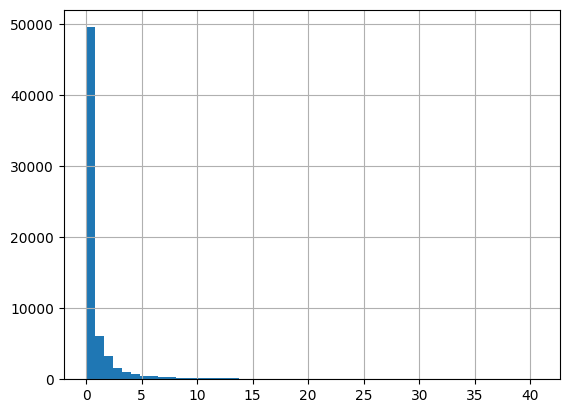

In [12]:
print ("Median", df_animals["stay_lenght"].median(), "-- true average months stayed")
print ("Mean", df_animals["stay_lenght"].mean(), "-- mean is skewed by animals with long stays")
print ("Mode", df_animals["stay_lenght"].mode(), "-- most likely transfered")
df_animals['stay_lenght'].hist(bins = 50)

### Is there a significant difference between length of stay for Dogs and Cats?
Average length of stay is slightly longer for cats.

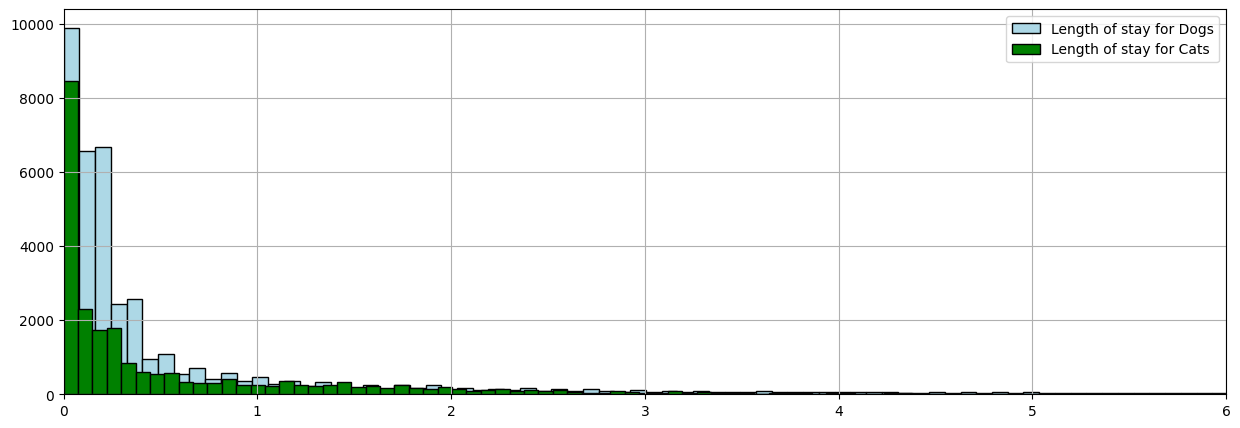

In [13]:
df_animals[df_animals["animal_type"] == "dog"]['stay_lenght'].hist(bins = 500,
                                                                   figsize=(15,5),
                                                                   color = "lightblue",
                                                                   ec="black",
                                                                   label='Length of stay for Dogs')
df_animals[df_animals["animal_type"] == "cat"]['stay_lenght'].hist(bins = 500,
                                                                   figsize=(15,5),
                                                                   color = "green",
                                                                   ec="black",
                                                                   label='Length of stay for Cats')
plt.xlim([0, 6])
plt.legend()

### Given an animal is adopted, is there a significant difference between length of stay for Dogs and Cats?
Average length of stay for adoptions is significantly longer for cats.

In [14]:
dog_adopted_records = df_animals[(df_animals["outcome_type"] == "adoption") & 
                                 (df_animals["animal_type"] == "dog")]
cat_adopted_records = df_animals[(df_animals["outcome_type"] == "adoption") &
                                 (df_animals["animal_type"] == "cat")]

print ("Dog Adopted Mean: ", dog_adopted_records["stay_lenght"].mean())
print ("Dog Adopted Median: ", dog_adopted_records["stay_lenght"].median())
print ("Cat Adopted Mean: ", cat_adopted_records["stay_lenght"].mean())
print ("Cat Adopted Median: ", cat_adopted_records["stay_lenght"].median())

Dog Adopted Mean:  1.4988650398582521
Dog Adopted Median:  0.29569395675475885
Cat Adopted Mean:  1.4626636370650528
Cat Adopted Median:  0.8542269861804144


### Given an animal is adopted, is there a significant difference between length of stay for Female vs Male dogs and cats?
Not a significant difference between Dogs, almost a significant difference between cats. Male animals are adopted faster across the board.

In [15]:
male_dog_adopted_records = dog_adopted_records[dog_adopted_records["income_sex"] == "male"]
female_dog_adopted_records = dog_adopted_records[dog_adopted_records["income_sex"] == "female"]
male_cat_adopted_records = cat_adopted_records[cat_adopted_records["income_sex"] == "male"]
female_cat_adopted_records = cat_adopted_records[cat_adopted_records["income_sex"] == "female"]

print ("Male Dog Adopted Mean: ", male_dog_adopted_records["stay_lenght"].mean())
print ("Female Dog Adopted Mean: ", female_dog_adopted_records["stay_lenght"].mean())
print ("Male Cat Adopted Mean: ", male_cat_adopted_records["stay_lenght"].mean())
print ("Female Cat Adopted Mean: ", female_cat_adopted_records["stay_lenght"].mean())

print ("Male vs Female Dog", ttest_ind(male_dog_adopted_records["stay_lenght"],
                                       female_dog_adopted_records["stay_lenght"]))
print ("Male vs Female Cat", ttest_ind(male_cat_adopted_records["stay_lenght"],
                                       female_cat_adopted_records["stay_lenght"]))

Male Dog Adopted Mean:  1.4831291911011661
Female Dog Adopted Mean:  1.5153828915032115
Male Cat Adopted Mean:  1.4053678360771993
Female Cat Adopted Mean:  1.5166744671998749
Male vs Female Dog Ttest_indResult(statistic=-0.6320941195569445, pvalue=0.5273331814302167)
Male vs Female Cat Ttest_indResult(statistic=-2.2367112788530945, pvalue=0.025327132262350508)


### What is the likelihood of outcome based on age?

### Dogs

In [16]:
dog_records = df_animals[df_animals["animal_type"] == "dog"]

bins = [0, 1, 3, 6, 12, 36,100]
dog_records['age_bins'] = pd.cut(dog_records['intake_age_months'], bins)
dog_records_outcome_age_gb = dog_records.groupby(['outcome_type','age_bins'])['age_bins'].count().unstack()

<AxesSubplot: title={'center': 'Distribution of outcomes based on dog age (%)'}>

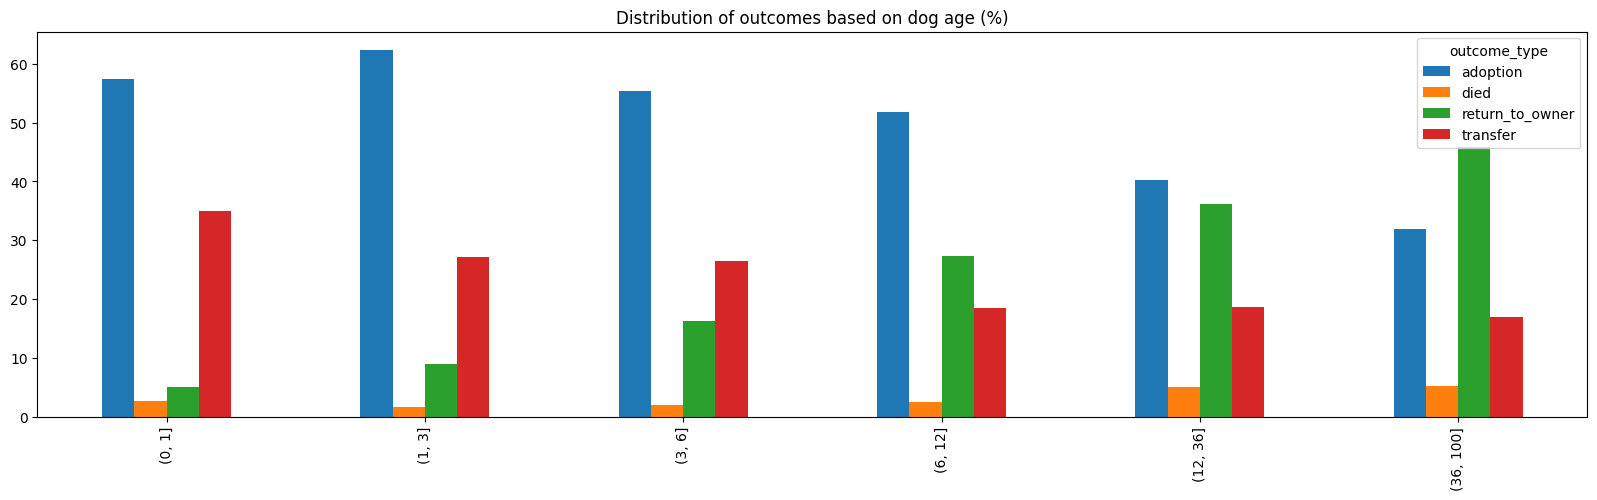

In [17]:
# Transform into a percentage
def get_perc_outcome(val,col):
    return float(val) / float(dog_records_outcome_age_gb[col].sum()) * 100

perc_dog_records_outcome_age_gb = pd.DataFrame()

for col in dog_records_outcome_age_gb.columns:
    perc_dog_records_outcome_age_gb[col] = dog_records_outcome_age_gb[col].apply(get_perc_outcome, args=(col,))

perc_dog_records_outcome_age_gb = perc_dog_records_outcome_age_gb.T
perc_dog_records_outcome_age_gb.plot(kind="bar", figsize=(20,5), title = "Distribution of outcomes based on dog age (%)")

### Cats

In [18]:
cat_records = df_animals[df_animals["animal_type"] == "cat"]

bins = [0, 1, 3, 6, 12, 36,100]
cat_records['age_bins'] = pd.cut(cat_records['intake_age_months'], bins)
cat_records_outcome_age_gb = cat_records.groupby(['outcome_type','age_bins'])['age_bins'].count().unstack()

<AxesSubplot: title={'center': 'Distribution of outcomes based on cat age (%)'}>

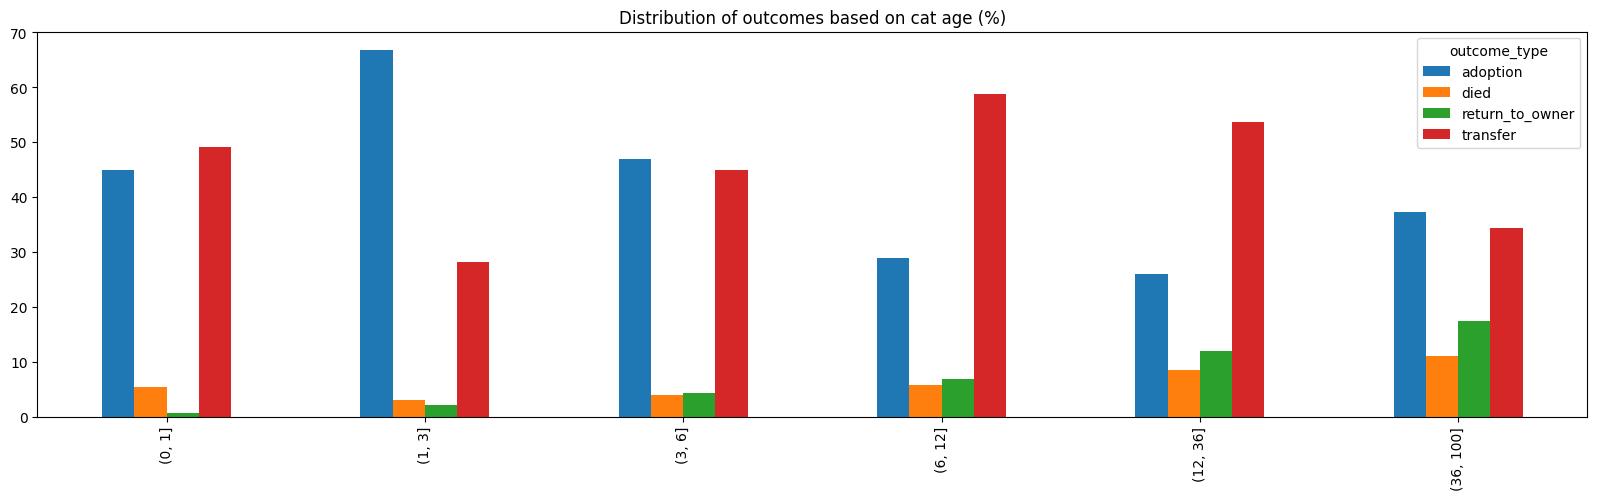

In [19]:
# Transform into a percentage
def get_perc_outcome(val,col):
    return float(val) / float(cat_records_outcome_age_gb[col].sum()) * 100

perc_cat_records_outcome_age_gb = pd.DataFrame()

for col in cat_records_outcome_age_gb.columns:
    perc_cat_records_outcome_age_gb[col] = cat_records_outcome_age_gb[col].apply(get_perc_outcome, args=(col,))

perc_cat_records_outcome_age_gb = perc_cat_records_outcome_age_gb.T
perc_cat_records_outcome_age_gb.plot(kind="bar", figsize=(20,5), title = "Distribution of outcomes based on cat age (%)")

### Are there certain months that people tend to make more adoptions on? What about certain days of the week?

<AxesSubplot: title={'center': 'Adoptions Throughout the Week'}>

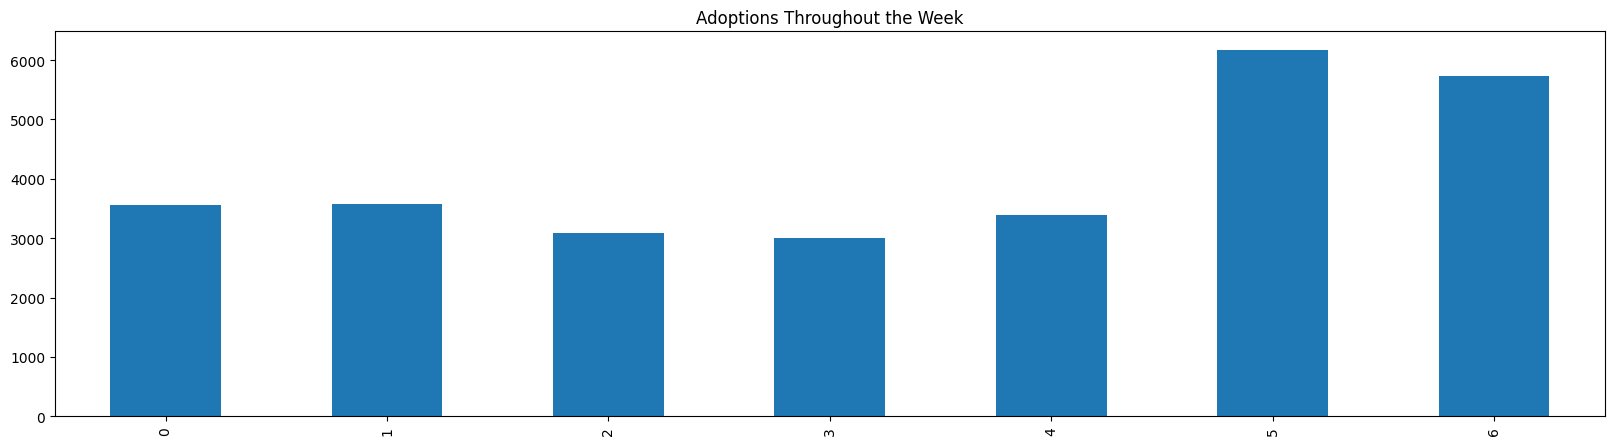

In [20]:
df_animals[df_animals['outcome_type'] == "adoption"]['weekday_num_outcome'].value_counts().sort_index()\
                                                                    .plot(kind="bar",
                                                                          figsize=(20,5),
                                                                          title = "Adoptions Throughout the Week")

<AxesSubplot: title={'center': 'Adoptions throughout the year'}>

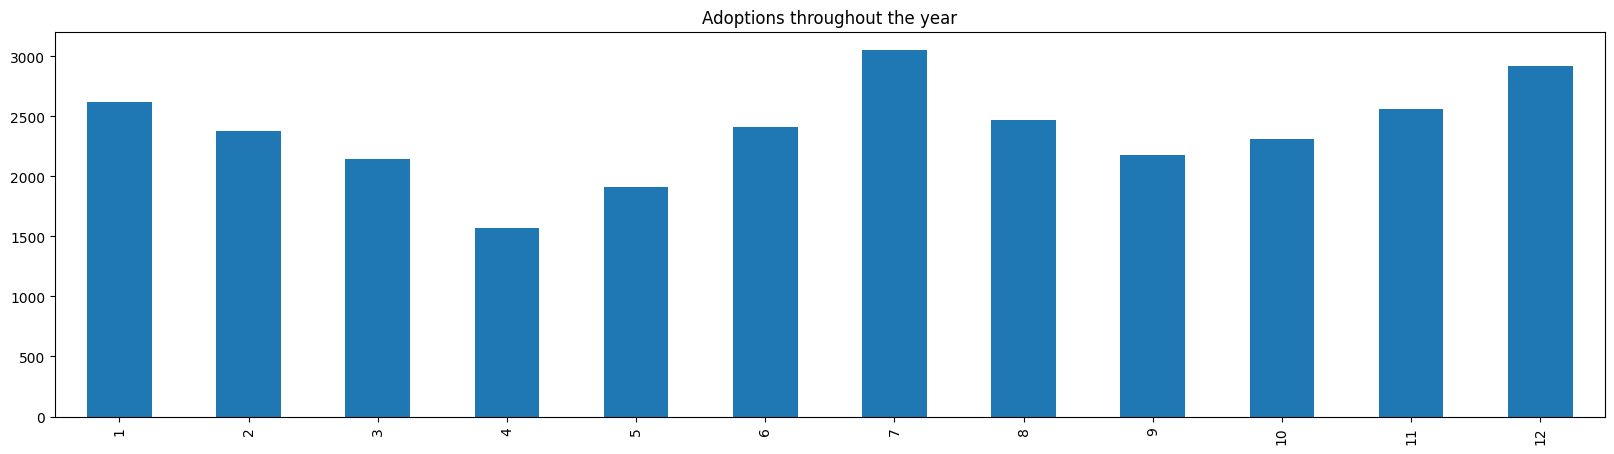

In [21]:
df_animals[df_animals['outcome_type'] == "adoption"]['month_num_outcome'].value_counts().sort_index()\
                                                                    .plot(kind='bar',
                                                                        figsize=(20,5),
                                                                        title = "Adoptions throughout the year")

# Model Building

In [22]:
#renaming the main dataframe for easier debugging
df_model = df_animals.copy()
#deleting unnesessary columns for adoption prediction
del df_model['outcome_subtype']
del df_model['outcome_sex']
del df_model['outcome_neutered']
del df_model["index"]
del df_model["name"]
del df_model["date_outcome"]
del df_model["time_outcome"]
del df_model["animal_breed"]
del df_model["animal_color"]
del df_model["outcome_age_months"]
del df_model["stay_lenght"]
del df_model["weekday_num_outcome"]
del df_model["weekend_outcome"]
del df_model["month_num_outcome"]
del df_model["daytime_outcome"]
del df_model["date_income"]
del df_model["time_income"]
#filling 'NaN' values with 0
df_model = df_model.fillna(0)

# Set the target column for prediction
df_model['target'] = np.where(df_model['outcome_type'] == 'adoption',1,0)
#deleting the outcome column from the main dataframe
del df_model["outcome_type"]

In [23]:
# apply numerical convert function
df_model = numerical_convert(df_model)
#dropping duplications in the dataframe
df_model = df_model.drop_duplicates()

In [24]:
#selectiong train features(X_train) and traing targets(y_train)
train_feature = ['intake_age_months', 'IsMix', 'weekday_num_income',
                 'weekend_income', 'month_num_income', 'daytime_income',
                 'euthanasia_request', 'owner_surrender', 'public_assist', 'stray',
                 'aged', 'feral', 'injured', 'normal', 'nursing', 'other', 'pregnant',
                 'sick', 'cat', 'dog', 'female', 'male', 'other_sex', 'intact',
                 'neutered', 'other_neutered', 'black', 'black/white', 'blue', 'brown',
                 'brown/white', 'calico', 'orange', 'other_color', 'red', 'sable', 'tan',
                 'torbie', 'tortie', 'white', 'yellow', 'bicolor', 'other_colortype',
                 'tricolor', 'unicolor', 'australian', 'border_collie', 'boxer',
                 'bulldog', 'chihuahua', 'dachshund', 'german_shepherd', 'hound',
                 'husky', 'longhair', 'mediumhair', 'other_breed', 'pit', 'poodle',
                 'retriever', 'rottweiler', 'schnauzer', 'shepherd', 'shorthair',
                 'siamese', 'staffordshire', 'terrier']

train_target = ['target']

#separating X_full_train and y_full_train datasets
train_df = df_model[train_feature].astype(float)
target_df = df_model[train_target].astype(float)

In [25]:
#splitting the dataframes into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.2, random_state=0)

In [26]:
## Trying out some of the most commonly used models ##

# LogisticRegression==============
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('='*20)
print('RandomForestClassifier')
print(f'accuracy of train set: {lr.score(X_train, y_train)}')
print(f'accuracy of test set: {lr.score(X_test, y_test)}')
y_prediction = lr.predict(X_test)
print('AUC of test set:', roc_auc_score(y_test,y_prediction))

# RandomForest==============
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('='*20)
print('RandomForestClassifier')
print(f'accuracy of train set: {rf.score(X_train, y_train)}')
print(f'accuracy of test set: {rf.score(X_test, y_test)}')
y_prediction = rf.predict(X_test)
print('AUC of test set:', roc_auc_score(y_test,y_prediction))

# XGBClassifier==============
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
print('='*20)
print('XGB Classifier')
print(f'accuracy of train set: {xgb_model.score(X_train, y_train)}')
print(f'accuracy of test set: {xgb_model.score(X_test, y_test)}')
y_prediction = xgb_model.predict(X_test)
print('AUC of test set:', roc_auc_score(y_test,y_prediction))

RandomForestClassifier
accuracy of train set: 0.6428983358049102
accuracy of test set: 0.6468940517383424
AUC of test set: 0.6362425829687893
RandomForestClassifier
accuracy of train set: 0.9495180425111222
accuracy of test set: 0.6502718734552645
AUC of test set: 0.6404720402790428
XGB Classifier
accuracy of train set: 0.7264170374031965
accuracy of test set: 0.6848739495798319
AUC of test set: 0.6792499635559885


### Parameter tuning

In [28]:
#looking for the best model params
#print(best_params(X_train,y_train))

# Create final model

In [29]:
# Final XGBClassifier==============
final_model = XGBClassifier(learning_rate = 0.06,
                            max_depth = 6,
                            max_leaves = 20,
                            n_estimators = 150)
final_model.fit(X_train, y_train)
print('='*20)
print('XGB Classifier')
print(f'accuracy of train set: {final_model.score(X_train, y_train)}')
print(f'accuracy of test set: {final_model.score(X_test, y_test)}')
y_prediction = final_model.predict(X_test)
print('AUC of test set:', roc_auc_score(y_test,y_prediction))

XGB Classifier
accuracy of train set: 0.6946572746745757
accuracy of test set: 0.6849563354753666
AUC of test set: 0.6794862370384952


In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_prediction)

array([[4970, 1945],
       [1879, 3344]])

## Check final model's feature importance
### (Drop features if needed)

In [31]:
sorted_idx = np.argsort(final_model.feature_importances_)[::-1]

for index in sorted_idx:
    print([X_train.columns[index], final_model.feature_importances_[index]]) 

['other_sex', 0.23669593]
['owner_surrender', 0.08350464]
['normal', 0.0734279]
['public_assist', 0.06885398]
['stray', 0.06253508]
['cat', 0.049838535]
['intake_age_months', 0.04087271]
['intact', 0.03502378]
['pit', 0.021444488]
['shorthair', 0.017799633]
['australian', 0.014195518]
['sick', 0.010801651]
['euthanasia_request', 0.010203663]
['tricolor', 0.009946678]
['shepherd', 0.009937104]
['german_shepherd', 0.009514905]
['chihuahua', 0.009166802]
['terrier', 0.00854483]
['staffordshire', 0.008412173]
['nursing', 0.008056018]
['other_breed', 0.007491288]
['month_num_income', 0.007469888]
['retriever', 0.0074601476]
['female', 0.007067074]
['IsMix', 0.0069007613]
['border_collie', 0.006186898]
['daytime_income', 0.0060606743]
['boxer', 0.0058525456]
['injured', 0.005790721]
['tortie', 0.005772777]
['white', 0.0057108663]
['sable', 0.005703516]
['husky', 0.005649614]
['hound', 0.005629782]
['poodle', 0.005589588]
['other', 0.0055606086]
['mediumhair', 0.005393586]
['longhair', 0.0053

### There is no significant overfitting so it makes little sense to change the variables even though some of them not contributing to the model at all

# Testing final model

### creating the input converter function

In [32]:
def convert_input(input_dict,
                  pd = pd,
                  all_lower = all_lower,
                  time_extra_features = time_extra_features,
                  dog_breed_bucketing = dog_breed_bucketing,
                  cat_breed_bucketing = cat_breed_bucketing,
                  color_bucketing = color_bucketing,
                  numerical_convert = numerical_convert,
                  train_feature = train_feature):
    
    df = pd.DataFrame([input_dict])
    df = all_lower(df)
    df['date_income']= pd.to_datetime(df['date_income'])
    df = time_extra_features(df)
    df['intake_age_months'] = df['intake_age_months'].astype(float)
    df['IsMix'] = df['animal_breed'].str.contains('mix',case=False).astype(int)
    df[['color_buckets','color_type']] = df['animal_color'].apply(color_bucketing)
    df['breed_buckets'] = df['animal_breed'].str.replace('_',' ').apply(dog_breed_bucketing)
    df['breed_buckets'] = df['animal_breed'].str.replace('_',' ').apply(cat_breed_bucketing)
    df = numerical_convert(df)
    
    missing = []
    for missing_col in train_feature:
        if missing_col not in df.columns:
            missing.append(missing_col)
    
    df[missing] = 0
    del df['date_income']
    del df['time_income']
    del df['animal_breed']
    del df['animal_color']
    df = df.astype(float)
    df = df[train_feature]
    
    return df

### Applying the function

In [41]:
test_input = {'animal_type':'cat',
              'intake_age_months':'1.0',
              'intake_age_months':'1.0',
              'date_income':'2022-10-15',
              'time_income':'12:20:00',
              'intake_type':'stray',
              'intake_condition': 'normal',
              'income_sex':'male',
              'income_neutered':'intact',
              'animal_breed': 'shorthair mix',
              'animal_color': 'blue_tabby'
    }

In [42]:
input_df = convert_input(test_input)

In [43]:
input_pred = final_model.predict(input_df)
print('test_input_pred:',input_pred)

test_input_pred: [1]


In [44]:
output_file = 'adoption_prediction.bin'
convert_input_drill = dill.dumps(convert_input)

with open(output_file, 'wb') as f_out:
    pickle.dump((convert_input_drill,final_model), f_out)

# Using final model

In [47]:
output_file = 'adoption_prediction.bin'

with open(output_file, 'rb') as f_in:
    convert_input2 ,final_model2 = pickle.load(f_in)
    
convert_input_undrill = dill.loads(convert_input2)

In [48]:
input_dic = {'animal_type':'dog',
             'intake_age_months':'1.0',
             'date_income':'2022-10-10',
             'time_income':'12:20:00',
             'intake_type':'stray',
             'intake_condition': 'normal',
             'income_sex':'male',
             'income_neutered':'intact',
             'animal_breed': 'pitbull',
             'animal_color': 'black/white'
            }

In [49]:
input_df = convert_input_undrill(input_dic)
input_pred = final_model2.predict(input_df)
print(input_pred)

[1]
